In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

from hloc import (
    extract_features,
    match_features,
    reconstruction,
    visualization,
    pairs_from_retrieval,
)

from hloc import (
    extract_features,
    localize_sfm,
    logger,
    match_features,
    pairs_from_covisibility,
    triangulation,
)

In [2]:
from hloc.sfm_utils import create_query_list_with_intrinsics, evaluate
import logging

import numpy as np

from hloc.utils.read_write_model import read_model, write_model

logger = logging.getLogger(__name__)


def create_reference_sfm(full_model, ref_model, blacklist=None, ext=".bin"):
    """Create a new COLMAP model with only training images."""
    logger.info("Creating the reference model.")
    ref_model.mkdir(exist_ok=True)
    cameras, images, points3D = read_model(full_model, ext)

    if blacklist is not None:
        with open(blacklist, "r") as f:
            blacklist = f.read().rstrip().split("\n")

    images_ref = dict()
    for id_, image in images.items():
        if blacklist and image.name in blacklist:
            continue
        images_ref[id_] = image

    points3D_ref = dict()
    for id_, point3D in points3D.items():
        ref_ids = [i for i in point3D.image_ids if i in images_ref]
        if len(ref_ids) == 0:
            continue
        points3D_ref[id_] = point3D._replace(image_ids=np.array(ref_ids))

    write_model(cameras, images_ref, points3D_ref, ref_model, ".bin")
    logger.info(f"Kept {len(images_ref)} images out of {len(images)}.")

In [3]:
SCENES = ["stairs"]
def run_scene(
    images,
    gt_dir,
    retrieval,
    outputs,
    results,
    num_covis,
    use_dense_depth,
    depth_dir=None,
):
    outputs.mkdir(exist_ok=True, parents=True)
    ref_sfm_sift = outputs / "sfm_sift"
    ref_sfm = outputs / "sfm_superpoint+superglue"
    query_list = outputs / "query_list_with_intrinsics.txt"

    feature_conf = {
        "output": "feats-superpoint-n4096-r1024",
        "model": {
            "name": "superpoint",
            "nms_radius": 3,
            "max_keypoints": 4096,
        },
        "preprocessing": {
            "globs": ["*.color.png"],
            "grayscale": True,
            "resize_max": 1024,
        },
    }
    matcher_conf = match_features.confs["superglue"]
    matcher_conf["model"]["sinkhorn_iterations"] = 5

    test_list = gt_dir / "list_test.txt"
    create_reference_sfm(gt_dir, ref_sfm_sift, test_list)
    create_query_list_with_intrinsics(gt_dir, query_list, test_list)

    features = extract_features.main(feature_conf, images, outputs, as_half=True)

    sfm_pairs = outputs / f"pairs-db-covis{num_covis}.txt"
    pairs_from_covisibility.main(ref_sfm_sift, sfm_pairs, num_matched=num_covis)
    sfm_matches = match_features.main(
        matcher_conf, sfm_pairs, feature_conf["output"], outputs
    )

    
    if not (use_dense_depth and ref_sfm.exists()):
        triangulation.main(
            ref_sfm, ref_sfm_sift, images, sfm_pairs, features, sfm_matches
        )
    if use_dense_depth:
        assert depth_dir is not None
        ref_sfm_fix = outputs / "sfm_superpoint+superglue+depth"
        correct_sfm_with_gt_depth(ref_sfm, depth_dir, ref_sfm_fix)
        ref_sfm = ref_sfm_fix

    loc_matches = match_features.main(
        matcher_conf, retrieval, feature_conf["output"], outputs
    )
    
    localize_sfm.main(
        ref_sfm,
        query_list,
        retrieval,
        features,
        loc_matches,
        results,
        covisibility_clustering=False,
        prepend_camera_name=True,
    )


In [4]:
import os
os.name == 'nt'

True

In [5]:
#gt_dirs = 'D:/gs-localization/datasets/360_v2/bonsai/full_views' / "/triangulated"
dataset = Path('D:/Hierarchical-Localization/datasets/7scenes')
outputs = Path('D:/Hierarchical-Localization/outputs/7scenes')

gt_dirs = dataset / "7scenes_sfm_triangulated/{scene}/triangulated"
retrieval_dirs = dataset / "7scenes_densevlad_retrieval_top_10"

all_results = {}
for scene in SCENES:
    logger.info(f'Working on scene "{scene}".')
    results = (
        outputs
        / scene
        / "results_{}.txt".format("dense" if False else "sparse")
    )
    run_scene(
            dataset / scene,
            Path(str(gt_dirs).format(scene=scene)),
            retrieval_dirs / f"{scene}_top10.txt",
            outputs / scene,
            results,
            30,
            False,
            depth_dir=dataset / f"depth/7scenes_{scene}/train/depth",
        )
    all_results[scene] = results

[2024/08/10 06:39:30 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-r1024',
 'preprocessing': {'globs': ['*.color.png'],
                   'grayscale': True,
                   'resize_max': 1024}}
[2024/08/10 06:39:30 hloc INFO] Found 6000 images in root D:\Hierarchical-Localization\datasets\7scenes\stairs.


'D:\\Hierarchical-Localization\\datasets\\7scenes\\stairs\\**\\*.color.png'


[2024/08/10 06:39:31 hloc INFO] Skipping the extraction.
[2024/08/10 06:39:31 hloc INFO] Reading the COLMAP model...
[2024/08/10 06:39:32 hloc INFO] Extracting image pairs from covisibility info...
100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:06<00:00, 324.61it/s]
[2024/08/10 06:39:38 hloc INFO] Found 60000 pairs.
[2024/08/10 06:39:38 hloc INFO] Matching local features with configuration:
{'model': {'name': 'superglue', 'sinkhorn_iterations': 5, 'weights': 'outdoor'},
 'output': 'matches-superglue'}
[2024/08/10 06:39:39 hloc INFO] Skipping the matching.
[2024/08/10 06:39:39 hloc WARNING] The database already exists, deleting it.
[2024/08/10 06:39:40 hloc INFO] Importing features into the database...
100%|████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2606.54it/s]
[2024/08/10 06:39:40 hloc INFO] Importing matches into the database...
100%|██████████████████████████████████████████

In [6]:
from hloc.utils.read_write_model import (
    qvec2rotmat,
    read_cameras_binary,
    read_cameras_text,
    read_images_binary,
    read_images_text,
    read_model,
    write_model,
)

def evaluate(model, results, list_file=None, ext=".bin", only_localized=False):
    predictions = {}
    with open(results, "r") as f:
        for data in f.read().rstrip().split("\n"):
            data = data.split()
            name = data[0]
            q, t = np.split(np.array(data[1:], float), [4])
            predictions[name] = (qvec2rotmat(q), t)
    if ext == ".bin":
        images = read_images_binary(model / "images.bin")
    else:
        images = read_images_text(model / "images.txt")
    name2id = {image.name: i for i, image in images.items()}

    if list_file is None:
        test_names = list(name2id)
    else:
        with open(list_file, "r") as f:
            test_names = f.read().rstrip().split("\n")

    errors_t = []
    errors_R = []
    for name in test_names:
        if name not in predictions:
            if only_localized:
                continue
            e_t = np.inf
            e_R = 180.0
        else:
            image = images[name2id[name]]
            R_gt, t_gt = image.qvec2rotmat(), image.tvec
            R, t = predictions[name]
            e_t = np.linalg.norm(-R_gt.T @ t_gt + R.T @ t, axis=0)
            cos = np.clip((np.trace(np.dot(R_gt.T, R)) - 1) / 2, -1.0, 1.0)
            e_R = np.rad2deg(np.abs(np.arccos(cos)))
        errors_t.append(e_t)
        errors_R.append(e_R)

    errors_t = np.array(errors_t)
    errors_R = np.array(errors_R)

    print(errors_t, errors_R)
    med_t = np.median(errors_t)
    med_R = np.median(errors_R)
    out = f"Results for file {results.name}:"
    out += f"\nMedian errors: {med_t:.3f}m, {med_R:.3f}deg"

    out += "\nPercentage of test images localized within:"
    threshs_t = [0.01, 0.02, 0.03, 0.05, 0.25, 0.5, 5.0]
    threshs_R = [1.0, 2.0, 3.0, 5.0, 2.0, 5.0, 10.0]
    for th_t, th_R in zip(threshs_t, threshs_R):
        ratio = np.mean((errors_t < th_t) & (errors_R < th_R))
        out += f"\n\t{th_t*100:.0f}cm, {th_R:.0f}deg : {ratio*100:.2f}%"
    logger.info(out)

In [28]:
gt_dir = dataset / f"{scene}/full_views/triangulated" 
evaluate(gt_dir, all_results[scene],  dataset / f"{scene}/train_views/triangulated"  / "list_test.txt")

[0.00158254 0.00346935 0.00951988 0.00440538 0.01043082 0.02724679
 0.02018888 0.00469466 0.01609652 0.00601256 0.0018671  0.00330023
 0.00328477 0.00182456 0.00973209 0.00231951 0.01975841 0.01626336
 0.00486122 0.02969457 0.00932213 0.00199688 0.01538679 0.00441542
 0.00372349 0.00199856 0.00142961 0.00096693 0.00302045 0.00324347
 0.00104286 0.00408916 0.00175641 0.00311949 0.00153703 0.00080674
 0.00261527 0.00126004 0.0019532  0.00333982 0.00205113 0.00360226
 0.00293606 0.00216385 0.00607682 0.00115649 0.00599533 0.00577858
 0.00155742] [0.03478587 0.04629702 0.06086304 0.0123035  0.01959788 0.11432085
 0.07558644 0.01605808 0.02159877 0.00977216 0.01962817 0.02456867
 0.01590634 0.0147703  0.0132203  0.00551177 0.01932324 0.04108409
 0.0124992  0.05362522 0.02944993 0.01198488 0.01568751 0.00828173
 0.05510971 0.03276008 0.01734252 0.00731569 0.0064608  0.03149496
 0.01605873 0.00172392 0.01477333 0.01754288 0.01055418 0.01882818
 0.01320381 0.02133345 0.01541778 0.00978175 0.00

In [ ]:
scene = "bonsai"

dataset = Path('D:/gs-localization/datasets/360_v2')
retrieval_dirs = dataset /"360_v2_netvlad_retrieval_top_5"
gt_dirs = dataset / f"{scene}/full_views/triangulated" 
outputs = Path('D:/gs-localization/output/360_v2')

results = (
    outputs
    / scene
    / "results_{}.txt".format("dense" if False else "sparse")
)
retrieval_dirs / f"{scene}_top5.txt"

In [ ]:
gt_dirs / "list_test.txt"

## Setup
In this notebook, we will run SfM reconstruction from scratch on a set of images. We choose the [South-Building dataset](https://openaccess.thecvf.com/content_cvpr_2013/html/Hane_Joint_3D_Scene_2013_CVPR_paper.html) - we will download it later. First, we define some paths.

In [2]:
images = Path("datasets/nerf_llff_data/room/images_4/")
outputs = Path("outputs/nerf_llff_data/room/")
sfm_pairs = outputs / "pairs-netvlad.txt"
sfm_dir = outputs / "sfm_superpoint+superglue"

retrieval_conf = extract_features.confs["netvlad"]
feature_conf = extract_features.confs["superpoint_aachen"]
matcher_conf = match_features.confs["superglue"]

## Download the dataset
The dataset is simply a set of images. The intrinsic parameters will be extracted from the EXIF data and refined with SfM.

In [3]:
if not images.exists():
    !wget https://cvg-data.inf.ethz.ch/local-feature-evaluation-schoenberger2017/South-Building.zip -P datasets/
    !unzip -q datasets/South-Building.zip -d datasets/

## Find image pairs via image retrieval
We extract global descriptors with NetVLAD and find for each image the most similar ones. For smaller dataset we can instead use exhaustive matching via `hloc/pairs_from_exhaustive.py`, which would find $\frac{n(n-1)}{2}$ images pairs.

In [4]:
retrieval_path = extract_features.main(retrieval_conf, images, outputs)
pairs_from_retrieval.main(retrieval_path, sfm_pairs, num_matched=5)

[2024/08/08 04:48:34 hloc INFO] Extracting local features with configuration:
{'model': {'name': 'netvlad'},
 'output': 'global-feats-netvlad',
 'preprocessing': {'resize_max': 1024}}
[2024/08/08 04:48:34 hloc INFO] Found 41 images in root datasets\nerf_llff_data\room\images_4.
[2024/08/08 04:48:34 hloc INFO] Skipping the extraction.
[2024/08/08 04:48:34 hloc INFO] Extracting image pairs from a retrieval database.
[2024/08/08 04:48:34 hloc INFO] Found 205 pairs.


## Extract and match local features

In [5]:
import pycolmap
feature_path = extract_features.main(feature_conf, images, outputs)
match_path = match_features.main(
    matcher_conf, sfm_pairs, feature_conf["output"], outputs)

[2024/08/08 04:48:34 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-r1024',
 'preprocessing': {'grayscale': True, 'resize_max': 1024}}
[2024/08/08 04:48:34 hloc INFO] Found 41 images in root datasets\nerf_llff_data\room\images_4.
[2024/08/08 04:48:34 hloc INFO] Skipping the extraction.
[2024/08/08 04:48:34 hloc INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}
[2024/08/08 04:48:34 hloc INFO] Skipping the matching.


## 3D reconstruction
Run COLMAP on the features and matches.

In [6]:
model = reconstruction.main(sfm_dir, images, sfm_pairs, feature_path, match_path)

[2024/08/08 04:48:45 hloc INFO] Creating an empty database...
[2024/08/08 04:48:45 hloc INFO] Importing images into the database...


TypeError: import_images(): incompatible function arguments. The following argument types are supported:
    1. (database_path: str, image_path: str, camera_mode: pycolmap.CameraMode = <CameraMode.AUTO: 0>, image_list: List[str] = [], options: pycolmap.ImageReaderOptions = <pycolmap.ImageReaderOptions object at 0x0000020E76A6EEB0>) -> None

Invoked with: WindowsPath('outputs/nerf_llff_data/room/sfm_superpoint+superglue/database.db'), WindowsPath('datasets/nerf_llff_data/room/images_4'), 0; kwargs: image_list=[], options={}

In [22]:
pycolmap.import_images?

Docstring:
import_images(database_path: str, image_path: str, camera_mode: pycolmap.CameraMode = <CameraMode.AUTO: 0>, image_list: List[str] = [], options: pycolmap.ImageReaderOptions = <pycolmap.ImageReaderOptions object at 0x000002B921B33FB0>) -> None

Import images into a database
Type:      builtin_function_or_method

## Visualization
We visualize some of the registered images, and color their keypoint by visibility, track length, or triangulated depth.

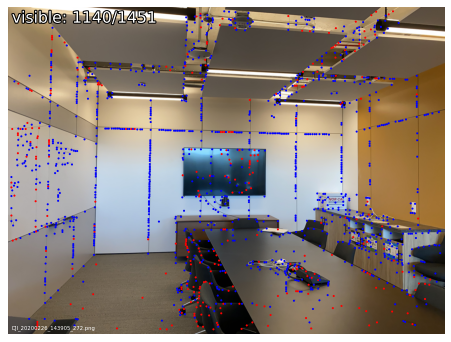

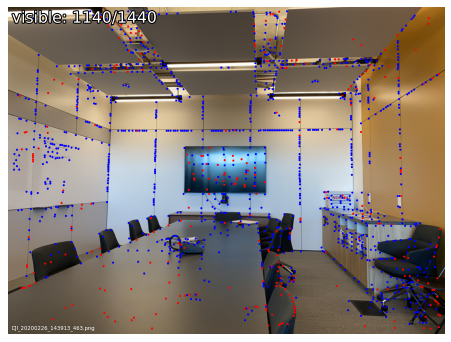

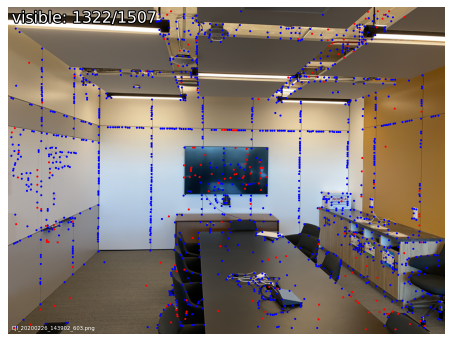

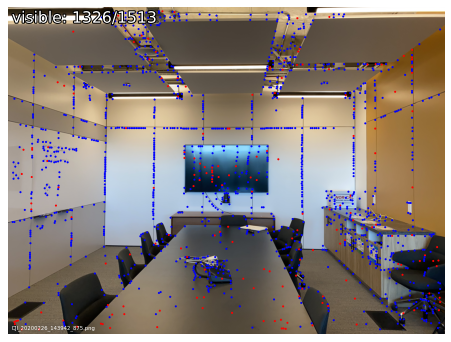

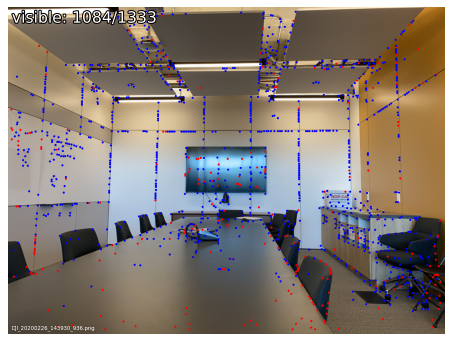

In [14]:
visualization.visualize_sfm_2d(model, images, color_by="visibility", n=5)

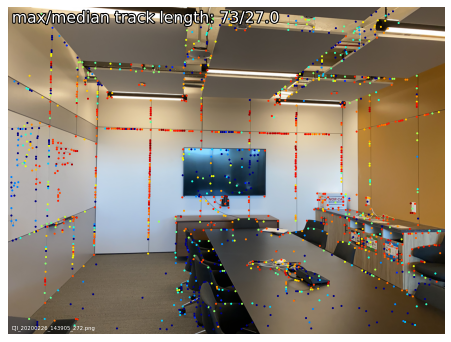

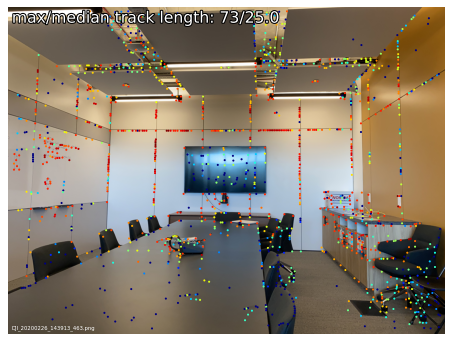

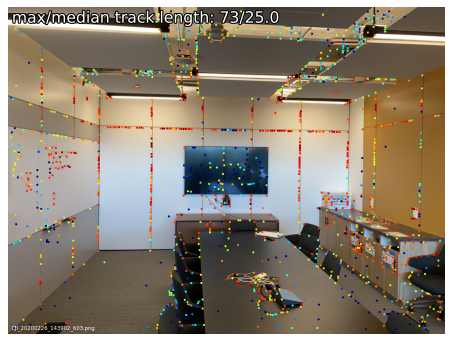

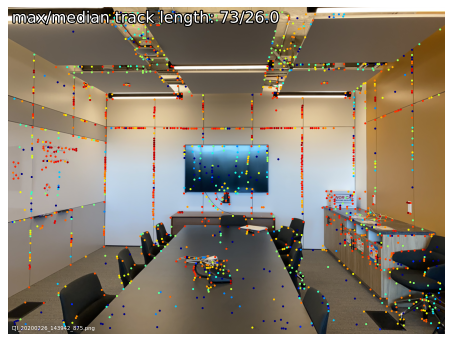

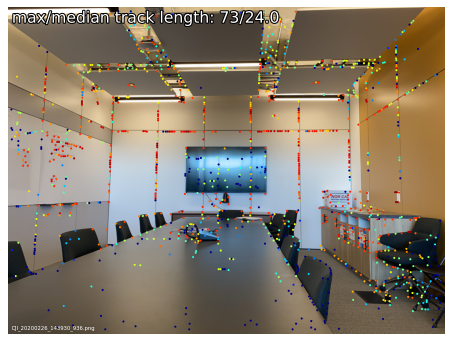

In [15]:
visualization.visualize_sfm_2d(model, images, color_by="track_length", n=5)

In [ ]:
visualization.visualize_sfm_2d(model, images, color_by="depth", n=5)